# Определение перспективного тарифа для телеком-компании

Компания «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Проанализируем поведение клиентов и сделаем вывод — какой тариф лучше.


**Описание тарифов**<br>

Тариф «Смарт»<br>
1.Ежемесячная плата: 550 рублей<br>
2.Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика<br>
3.Стоимость услуг сверх тарифного пакета: 
* минута разговора: 3 рубля («Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута); 
* сообщение: 3 рубля; 
* 1 Гб интернет-трафика: 200 рублей.


1.Тариф «Ультра»<br>
2.Ежемесячная плата: 1950 рублей<br>
3.Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика<br>
Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль; 
* сообщение: 1 рубль; 
* 1 Гб интернет-трафика: 150 рублей.

Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

**Цель исследования:** выяснить на основе выборки клиентов, какой тариф «Смарт» или «Ультра» выгоднее для компании, путем проверки двух гипотез:

* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Содержание**
    
    
1. [Изучение данных из файла](#open)
    
    
2. [Предобработка данных](#preproc)
     
    
3. [Предварительный анализ данных](#pred)


4. [Проверка гипотез](#research)
    * [4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются](#ans1)
    * [4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов](#ans2)
    
    
4. [Общий вывод](#summary)

<a id="open"></a>
## 1. Изучение данных из файла

**Описание данных:**


Таблица users (информация о пользователях):

user_id — уникальный идентификатор пользователя<br>
first_name — имя пользователя<br>
last_name — фамилия пользователя<br>
age — возраст пользователя (годы)<br>
reg_date — дата подключения тарифа (день, месяц, год)<br>
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)<br>
city — город проживания пользователя<br>
tarif — название тарифного плана

Таблица calls (информация о звонках):

id — уникальный номер звонка<br>
call_date — дата звонка<br>
duration — длительность звонка в минутах<br>
user_id — идентификатор пользователя, сделавшего звонок<br>

Таблица messages (информация о сообщениях):

id — уникальный номер сообщения<br>
message_date — дата сообщения<br>
user_id — идентификатор пользователя, отправившего сообщение<br>

Таблица internet (информация об интернет-сессиях):

id — уникальный номер сессии<br>
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)<br>
session_date — дата интернет-сессии<br>
user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

tariff_name — название тарифа<br>
rub_monthly_fee — ежемесячная абонентская плата в рублях<br>
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату<br>
messages_included — количество сообщений в месяц, включённых в абонентскую плату<br>
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)<br>
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)<br>
rub_per_message — стоимость отправки сообщения сверх тарифного пакета<br>
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)<br>

In [1]:
# Импортируем библиотеки

import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
from scipy import stats as st

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [2]:
# Изучаем таблицу звонков

calls = pd.read_csv('/datasets/calls.csv', sep = ',' )
display(calls.head(10))
calls.tail(10)
calls.sample(5)
calls.info()
calls.describe().T

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,count,mean,std,min,25%,50%,75%,max
duration,"202,607.00",6.76,5.84,0.00,1.30,6.00,10.70,38.00
user_id,"202,607.00","1,253.94",144.72,"1,000.00","1,126.00","1,260.00","1,379.00","1,499.00"


In [3]:
# Изучаем таблицу интернет сессий

internet = pd.read_csv('/datasets/internet.csv', sep = ',' )
display(internet.head(10))
internet.tail(10)
internet.sample(5)
internet.info()
internet.describe().T

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,"149,396.00","74,697.50","43,127.05",0.00,"37,348.75","74,697.50","112,046.25","149,395.00"
mb_used,"149,396.00",370.19,278.30,0.00,138.19,348.01,559.55,"1,724.83"
user_id,"149,396.00","1,252.10",144.05,"1,000.00","1,130.00","1,251.00","1,380.00","1,499.00"


In [4]:
# Изучаем таблицу sms

messages = pd.read_csv('/datasets/messages.csv', sep = ',' )
display(messages.head(10))
messages.tail(10)
messages.sample(5)
messages.info()
messages.describe().T

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,count,mean,std,min,25%,50%,75%,max
user_id,"123,036.00","1,256.99",143.52,"1,000.00","1,134.00","1,271.00","1,381.00","1,499.00"


In [5]:
# Изучаем таблицу тарифов

tariffs = pd.read_csv('/datasets/tariffs.csv', sep = ',' )
display(tariffs.head(10))
tariffs.tail(10)
# tariffs.sample(5)
tariffs.info()
tariffs.describe().T

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,count,mean,std,min,25%,50%,75%,max
messages_included,2.00,525.00,671.75,50.00,287.50,525.00,762.50,"1,000.00"
mb_per_month_included,2.00,"23,040.00","10,861.16","15,360.00","19,200.00","23,040.00","26,880.00","30,720.00"
minutes_included,2.00,"1,750.00","1,767.77",500.00,"1,125.00","1,750.00","2,375.00","3,000.00"
rub_monthly_fee,2.00,"1,250.00",989.95,550.00,900.00,"1,250.00","1,600.00","1,950.00"
rub_per_gb,2.00,175.00,35.36,150.00,162.50,175.00,187.50,200.00
rub_per_message,2.00,2.00,1.41,1.00,1.50,2.00,2.50,3.00
rub_per_minute,2.00,2.00,1.41,1.00,1.50,2.00,2.50,3.00


In [6]:
# Изучаем таблицу пользователей

users = pd.read_csv('/datasets/users.csv', sep = ',' )
display(users.query('churn_date.notna()').head(10))
users.tail(10)
users.sample(5)
users.info()
users['tariff'].unique()
users.describe().T

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,count,mean,std,min,25%,50%,75%,max
user_id,500.00,"1,249.50",144.48,"1,000.00","1,124.75","1,249.50","1,374.25","1,499.00"
age,500.00,46.59,16.67,18.00,32.00,46.00,62.00,75.00


### Вывод

Данные открыты и изучены.

Названия колонок выглядят приемлимо. Найдена колонка без названия совпадающая с индексом в таблице internet, удалим ее.

Найдены пропуски в поле таблицы users: 
* churn_date    

Это дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).

Некоректные типы данных:


Таблица calls

* call_date следует привести к типу datetime, округлив до дней
* duration снизим битность поля
* user_id снизим битность поля

Таблица internet

* session_date следует привести к типу datetime, округлив до дней
* mb_used снизим битность поля
* user_id снизим битность поля

Таблица messages

* message_date следует привести к типу datetime, округлив до дней
* user_id снизим битность поля

Таблица tariffs

* messages_included снизим битность поля
* mb_per_month_included снизим битность поля
* minutes_included снизим битность поля
* rub_monthly_fee снизим битность поля
* rub_per_gb снизим битность поля
* rub_per_message снизим битность поля
* rub_per_minute снизим битность поля

Таблица users
* user_id снизим битность поля
* age снизим битность поля
* churn_date следует привести к типу datetime, округлив до дней
* reg_date следует привести к типу datetime, округлив до дней


<a id="preproc"></a>
## 2. Предобработка данных

Удалим поле Unnamed: 0 из internet

In [7]:
try:
    internet.rename({"Unnamed: 0":"del"}, axis="columns", inplace=True)
    internet.drop(["del"], axis=1)
except:
    print('Поле удалено')
    print()
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
del             149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Изменим типы данных в соответствии с нашими решениями.

In [8]:
# Меняем текстовые даты на datetime

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%dT%H:%M:%S').dt.round('1d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%dT%H:%M:%S').dt.round('1d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%dT%H:%M:%S').dt.round('1d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%dT%H:%M:%S').dt.round('1d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%dT%H:%M:%S').dt.round('1d')

# Снижаем битность у оставшихся числовых полей
calls['duration'] = calls['duration'].astype('float32')
calls['user_id'] = calls['user_id'].astype('int32')
internet['mb_used'] = internet['mb_used'].astype('int16')
internet['user_id'] = internet['user_id'].astype('int32')
messages['user_id'] = messages['user_id'].astype('int32')
tariffs['messages_included'] = tariffs['messages_included'].astype('int16')
tariffs['mb_per_month_included'] = tariffs['mb_per_month_included'].astype('int32')
tariffs['minutes_included'] = tariffs['minutes_included'].astype('int16')
tariffs['rub_monthly_fee'] = tariffs['rub_monthly_fee'].astype('int16')
tariffs['rub_per_gb'] = tariffs['rub_per_gb'].astype('int16')
tariffs['rub_per_message'] = tariffs['rub_per_message'].astype('int16')
tariffs['rub_per_minute'] = tariffs['rub_per_minute'].astype('int16')
users['age'] = users['age'].astype('int8')
users['user_id'] = users['user_id'].astype('int32')

calls.info()
internet.info()
messages.info()
users.info()
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float32
user_id      202607 non-null int32
dtypes: datetime64[ns](1), float32(1), int32(1), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
del             149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null int16
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int32
dtypes: datetime64[ns](1), int16(1), int32(1), int64(1), object(1)
memory usage: 4.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int32
dtypes: datetime64[ns](1

Типы данных успешно изменены, использование памяти сокращено почти в 2 раза.

Посчитаем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя

In [9]:
# Округлим длительность каждого звонка в большую сторону согласно условиям задачи.
calls['duration'] = np.ceil(calls['duration'])

users_calls = users.merge(calls, how='left', on='user_id').pivot_table(index=['user_id', calls['call_date'].dt.month], values='duration', aggfunc=['sum', 'count']).reset_index()
# users_calls = users.merge(calls, how='left', on='user_id').pivot_table(index=['user_id', calls['call_date']], values='duration', aggfunc=['sum', 'count']).reset_index()
users_calls.columns = ['user_id','mnth','sum_duration', 'cnt_calls']
display(users_calls.sort_values(['user_id', 'mnth']).head(15))

,user_id,mnth,sum_duration,cnt_calls
0,1000,5.00,159.00,22
1,1000,6.00,172.00,43
2,1000,7.00,340.00,47
3,1000,8.00,408.00,52
4,1000,9.00,466.00,58
5,1000,10.00,350.00,57
6,1000,11.00,338.00,43
7,1000,12.00,333.00,46
8,1001,11.00,430.00,59
9,1001,12.00,414.00,63


Посчитаем количество отправленных сообщений по месяцам для каждого пользователя

In [10]:
# users_sms = users.merge(messages, how='left', on='user_id').pivot_table(index=['user_id', messages['message_date']], values='id', aggfunc='count').reset_index()
users_sms = users.merge(messages, how='left', on='user_id').pivot_table(index=['user_id', messages['message_date'].dt.month], values='id', aggfunc='count').reset_index()
users_sms.columns = ['user_id','mnth', 'cnt_sms']
display(users_sms.sort_values(['user_id', 'mnth']).head(15))

,user_id,mnth,cnt_sms
0,1000,5.00,22
1,1000,6.00,60
2,1000,7.00,75
3,1000,8.00,81
4,1000,9.00,57
5,1000,10.00,73
6,1000,11.00,58
7,1000,12.00,70
8,1001,11.00,0
9,1002,6.00,4


Посчитаем объем израсходованного интернет-трафика по месяцам для каждого пользователя

In [11]:
# users_internet = users.merge(internet, how='left', on='user_id').pivot_table(index=['user_id', internet['session_date']], values='mb_used', aggfunc='sum').reset_index()
users_internet = users.merge(internet, how='left', on='user_id').pivot_table(index=['user_id', internet['session_date'].dt.month], values='mb_used', aggfunc='sum').reset_index()
users_internet.columns = ['user_id','mnth', 'sum_mb']
display(users_internet.sort_values(['user_id', 'mnth']).head(15))

,user_id,mnth,sum_mb
0,1000,5.00,"2,252.00"
1,1000,6.00,"23,213.00"
2,1000,7.00,"13,988.00"
3,1000,8.00,"14,043.00"
4,1000,9.00,"14,556.00"
5,1000,10.00,"14,690.00"
6,1000,11.00,"14,745.00"
7,1000,12.00,"9,808.00"
8,1001,11.00,"18,405.00"
9,1001,12.00,"14,018.00"


Посчитаем помесячную выручку с каждого пользователя

In [12]:
# объединим все требуемые таблицы

users_info_all = users.merge(users_calls,on=['user_id'],how='left').merge(users_sms,on=['user_id','mnth'],how='left').merge(users_internet,on=['user_id','mnth'],how='left').merge(tariffs,left_on='tariff',right_on='tariff_name',how='left')

display(users_info_all.sort_values(['user_id', 'mnth']).head(15))

display(users_info_all.describe().T)

# Заполним пропуски в sms и sum_mb,
# предположим что в эти периоды данные пользователи не совершали звонков и не использовали интернет
users_info_all['cnt_sms'] = users_info_all['cnt_sms'].fillna(0)
users_info_all['sum_mb'] = users_info_all['sum_mb'].fillna(0)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,mnth,sum_duration,cnt_calls,cnt_sms,sum_mb,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5.00,159.00,22,22.00,"2,252.00",1000,30720,3000,1950,150,1,1,ultra
1,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,6.00,172.00,43,60.00,"23,213.00",1000,30720,3000,1950,150,1,1,ultra
2,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,7.00,340.00,47,75.00,"13,988.00",1000,30720,3000,1950,150,1,1,ultra
3,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.00,408.00,52,81.00,"14,043.00",1000,30720,3000,1950,150,1,1,ultra
4,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,9.00,466.00,58,57.00,"14,556.00",1000,30720,3000,1950,150,1,1,ultra
5,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,10.00,350.00,57,73.00,"14,690.00",1000,30720,3000,1950,150,1,1,ultra
6,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,11.00,338.00,43,58.00,"14,745.00",1000,30720,3000,1950,150,1,1,ultra
7,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,12.00,333.00,46,70.00,"9,808.00",1000,30720,3000,1950,150,1,1,ultra
8,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11.00,430.00,59,0.00,"18,405.00",50,15360,500,550,200,3,3,smart
9,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,12.00,414.00,63,nan,"14,018.00",50,15360,500,550,200,3,3,smart


,count,mean,std,min,25%,50%,75%,max
user_id,"3,463.00","1,257.50",143.55,"1,000.00","1,135.00","1,262.00","1,382.00","1,499.00"
age,"3,463.00",46.66,16.57,18.00,32.00,46.00,62.00,75.00
mnth,"3,463.00",8.20,2.93,1.00,6.00,9.00,11.00,12.00
sum_duration,"3,463.00",418.78,258.64,0.00,239.50,419.00,576.00,"1,628.00"
cnt_calls,"3,463.00",58.50,35.71,0.00,34.00,59.00,80.00,239.00
cnt_sms,"2,927.00",40.72,34.92,0.00,13.00,33.00,59.00,223.00
sum_mb,"3,234.00","16,868.78","7,774.23",0.00,"12,258.75","16,760.50","21,173.25","49,701.00"
messages_included,"3,463.00",334.20,435.06,50.00,50.00,50.00,"1,000.00","1,000.00"
mb_per_month_included,"3,463.00","19,955.14","7,034.22","15,360.00","15,360.00","15,360.00","30,720.00","30,720.00"
minutes_included,"3,463.00","1,247.91","1,144.89",500.00,500.00,500.00,"3,000.00","3,000.00"


In [13]:
print(users_info_all.user_id.nunique())

500

In [14]:
print(users_info_all.shape)

(3463, 21)

In [15]:
# Расчитаем выручку

# Выручка по звонкам
users_info_all['rev_calls'] = (np.where(users_info_all['sum_duration']>users_info_all['minutes_included'],
(users_info_all['sum_duration']-users_info_all['minutes_included'])*users_info_all['rub_per_minute'], 0))

# Выручка по смс
users_info_all['rev_sms'] = (np.where(users_info_all['cnt_sms']>users_info_all['messages_included'],
(users_info_all['cnt_sms']-users_info_all['messages_included'])*users_info_all['rub_per_message'], 0))

# Выручка по интернет трафику
users_info_all['rev_inet'] = (np.where(users_info_all['sum_mb']>users_info_all['mb_per_month_included'],
np.ceil((users_info_all['sum_mb']-users_info_all['mb_per_month_included'])/1000)*users_info_all['rub_per_gb'], 0))
                             
users_info_all['revenue'] = users_info_all['rub_monthly_fee']+users_info_all['rev_calls']+users_info_all['rev_sms']+users_info_all['rev_inet']


display(users_info_all.describe().T)
users_info_all[['user_id','mnth','revenue']].sort_values('revenue').head(15)
display(users_info_all[['user_id','mnth','revenue']].sort_values('revenue').tail(15))

,count,mean,std,min,25%,50%,75%,max
user_id,"3,463.00","1,257.50",143.55,"1,000.00","1,135.00","1,262.00","1,382.00","1,499.00"
age,"3,463.00",46.66,16.57,18.00,32.00,46.00,62.00,75.00
mnth,"3,463.00",8.20,2.93,1.00,6.00,9.00,11.00,12.00
sum_duration,"3,463.00",418.78,258.64,0.00,239.50,419.00,576.00,"1,628.00"
cnt_calls,"3,463.00",58.50,35.71,0.00,34.00,59.00,80.00,239.00
cnt_sms,"3,463.00",34.42,35.32,0.00,5.00,25.00,53.00,223.00
sum_mb,"3,463.00","15,753.29","8,603.41",0.00,"10,767.00","16,203.00","20,802.50","49,701.00"
messages_included,"3,463.00",334.20,435.06,50.00,50.00,50.00,"1,000.00","1,000.00"
mb_per_month_included,"3,463.00","19,955.14","7,034.22","15,360.00","15,360.00","15,360.00","30,720.00","30,720.00"
minutes_included,"3,463.00","1,247.91","1,144.89",500.00,500.00,500.00,"3,000.00","3,000.00"


,user_id,mnth,revenue
2035,1306,12.00,"4,350.00"
3188,1462,12.00,"4,366.00"
3145,1456,11.00,"4,369.00"
1422,1216,12.00,"4,393.00"
1720,1261,11.00,"4,523.00"
3379,1486,11.00,"4,787.00"
1578,1240,8.00,"4,800.00"
795,1124,10.00,"4,800.00"
879,1138,8.00,"4,924.00"
617,1098,12.00,"5,025.00"


In [16]:
users_info_all['revenue'].unique()

array([1950., 1350.,  550., 1150., 1550.,  950.,  886., 1186.,  835.,
        772.,  949.,  559., 1219.,  694.,  838.,  750.,  685.,  981.,
       1750., 1015.,  990.,  562., 2550., 2350., 1356., 1995., 1540.,
       2553., 2150., 2950., 3350., 3150., 2750., 2159., 2753., 1019.,
       3037., 1838., 3204., 1004., 1229., 1983., 1631., 1672.,  986.,
       3321., 3900., 2850., 1906.,  781.,  592., 1009.,  739.,  959.,
        655., 1061., 2919., 1998., 2319., 1087., 1723.,  718.,  703.,
        688.,  679.,  667., 1482.,  676., 1045.,  736., 1013., 1171.,
       2028., 2837., 1646., 2610., 1813., 1640., 1697.,  589.,  753.,
       1359.,  553., 1112.,  840., 1057., 3233., 5691., 2186., 1661.,
        571., 2165.,  995.,  971., 2192.,  759., 2216.,  762., 1885.,
       2115., 3581., 3979., 2700.,  601., 1942., 2788., 2130., 2267.,
       1765., 1157., 1476., 1488., 1815., 1077., 1905., 2219., 1245.,
       1665., 1103.,  924., 2004., 2441., 1321., 2210., 1553., 2463.,
       2965., 1131.,

### Вывод

Предобработка проведена: 
* типы данных изменены на более корректные;
* удалена дублирующая индекс колонка без названия;
* данные сгруппированы по месяцам и собраны в одну таблицу;
* проведены расчеты необходимые для дальнейшего исследования.

<a id="pred"></a>
## 3. Предварительный анализ данных

Опишем поведение клиентов оператора, исходя из данной выборки

tariff_name
smart   383.81
ultra   500.70
Name: sum_duration, dtype: float32

tariff_name
smart    45,360.36
ultra   107,845.98
Name: sum_duration, dtype: float32

tariff_name
smart   212.98
ultra   328.40
Name: sum_duration, dtype: float32

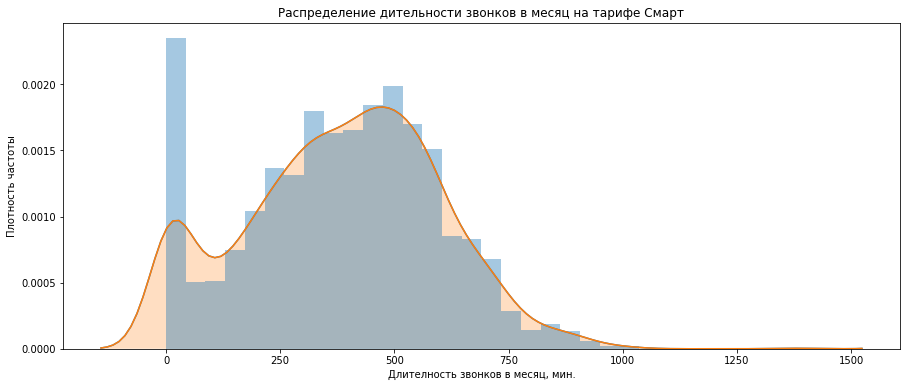

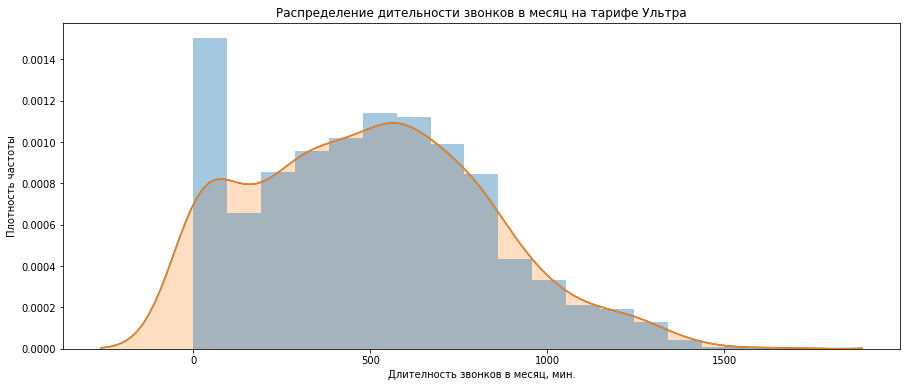

In [17]:
# Посчитаем сколько минут разговора в среднем требуется пользователям каждого тарифа в месяц
# display(users_info_all.groupby(['mnth','tariff_name'])['sum_duration'].mean())
display(users_info_all.groupby(['tariff_name'])['sum_duration'].mean())

# Посчитаем дисперсию минут разговора пользователей каждого тарифа в месяц
display(users_info_all.groupby(['tariff_name'])['sum_duration'].var())

# Посчитаем стандартное отклонение минут разговора пользователей каждого тарифа в месяц
display(users_info_all.groupby(['tariff_name'])['sum_duration'].std())

# hist = users_info_all['sum_duration'].plot(kind='hist',  alpha=0.7, figsize=(10, 5),  density=True)
# hist = users_info_all['sum_duration'].plot.kde()

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb_plot = sb.distplot(users_info_all.query('tariff_name=="smart"')['sum_duration'])
fig = sb_plot.get_figure()
sb_plot = sb.kdeplot(users_info_all.query('tariff_name=="smart"')['sum_duration'], shade=True)
fig = sb_plot.get_figure()
sb_plot.set(xlabel='Длителность звонков в месяц, мин.', ylabel='Плотность частоты', title='Распределение дительности звонков в месяц на тарифе Смарт') 
plt.legend([],[], frameon=False)
plt.show()


fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb_plot = sb.distplot(users_info_all.query('tariff_name=="ultra"')['sum_duration'])
fig = sb_plot.get_figure()
sb_plot = sb.kdeplot(users_info_all.query('tariff_name=="ultra"')['sum_duration'], shade=True)
fig = sb_plot.get_figure()
sb_plot.set(xlabel='Длителность звонков в месяц, мин.', ylabel='Плотность частоты', title='Распределение дительности звонков в месяц на тарифе Ультра') 
plt.legend([],[], frameon=False)
plt.show()


На тарифе Смарт месячное распределение длительности звонков похоже на нормальное, если не считать пика около нуля минут из-за непринятых вызовов. Значения распределены вокруг среднего (383.81 мин/мес) с дисперсией 45360.56 и стандартным отклонением 212.98.
Распределение ассиметрично с положительной скошенностью. 

На тарифе Ультра месячное распределение длительности звонков также похоже на нормальное. Значения распределены вокруг среднего (500.70 мин/мес) с дисперсией 107845.98 и стандартным отклонением 328.40.
Распределение ассиметрично с положительной скошенностью. Стандартное отклонение значений значительно выше, чем на тарифе Смарт (на 115,42 мин), среднее заметно выше (на 116,89).


tariff_name
smart   30.01
ultra   44.74
Name: cnt_sms, dtype: float64

tariff_name
smart     798.69
ultra   2,148.04
Name: cnt_sms, dtype: float64

tariff_name
smart   28.26
ultra   46.35
Name: cnt_sms, dtype: float64

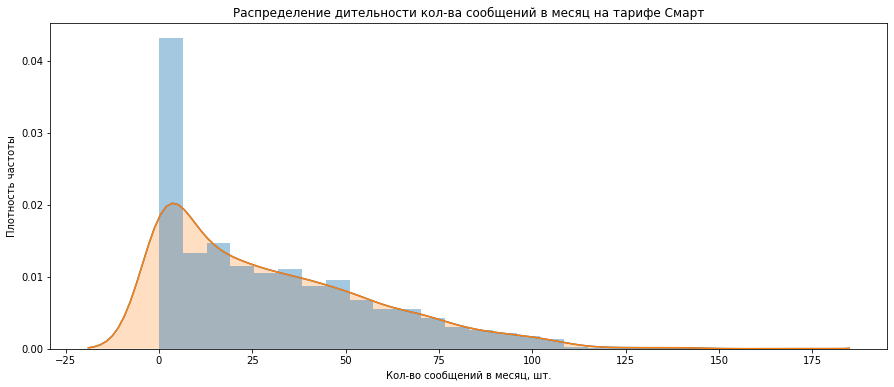

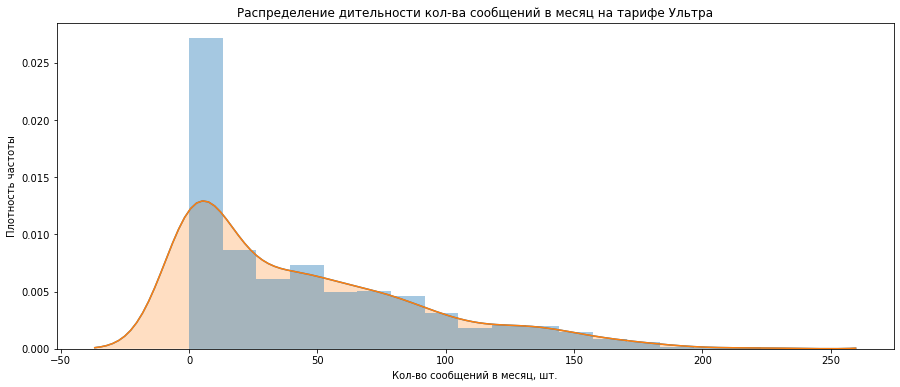

In [18]:
# Посчитаем сколько сообщений в среднем требуется пользователям каждого тарифа в месяц
# display(users_info_all.groupby(['mnth','tariff_name'])['sum_duration'].mean())
display(users_info_all.groupby(['tariff_name'])['cnt_sms'].mean())

# Посчитаем дисперсию кол-ва сообщений пользователей каждого тарифа в месяц
display(users_info_all.groupby(['tariff_name'])['cnt_sms'].var())

# Посчитаем стандартное отклонение кол-ва сообщений пользователей каждого тарифа в месяц
display(users_info_all.groupby(['tariff_name'])['cnt_sms'].std())

# hist = users_info_all['sum_duration'].plot(kind='hist',  alpha=0.7, figsize=(10, 5),  density=True)
# hist = users_info_all['sum_duration'].plot.kde()


fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb_plot = sb.distplot(users_info_all.query('tariff_name=="smart"')['cnt_sms'])
fig = sb_plot.get_figure()
sb_plot = sb.kdeplot(users_info_all.query('tariff_name=="smart"')['cnt_sms'], shade=True)
fig = sb_plot.get_figure()
sb_plot.set(xlabel='Кол-во сообщений в месяц, шт.', ylabel='Плотность частоты', title='Распределение дительности кол-ва сообщений в месяц на тарифе Смарт') 
plt.legend([],[], frameon=False)
plt.show()


fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb_plot = sb.distplot(users_info_all.query('tariff_name=="ultra"')['cnt_sms'])
fig = sb_plot.get_figure()
sb_plot = sb.kdeplot(users_info_all.query('tariff_name=="ultra"')['cnt_sms'], shade=True)
fig = sb_plot.get_figure()
sb_plot.set(xlabel='Кол-во сообщений в месяц, шт.', ylabel='Плотность частоты', title='Распределение дительности кол-ва сообщений в месяц на тарифе Ультра') 
plt.legend([],[], frameon=False)
plt.show()




На тарифе Смарт месячное распределение отправленных сообщений похоже на распределение Пуассона, пик около нуля минут связан с нашим предположением о пропусках. Значения распределены вокруг среднего (около 30 сообщений/мес) с дисперсией 798.69 и стандартным отклонением 28.26.
Распределение ассиметрично с положительной скошенностью. 

На тарифе Ультра месячное распределение похожее. Значения распределены вокруг среднего (44.74 сообщений/мес) с дисперсией 2148.04 и стандартным отклонением 46.35.
Распределение ассиметрично с положительной скошенностью. Дисперсия значений значительно выросла, по сравнению с тарифом Смарт, (на 1349.35), среднее выше на 14,73.


tariff_name
smart   14,820.99
ultra   17,937.35
Name: sum_mb, dtype: float64

tariff_name
smart    51,239,880.88
ultra   120,669,673.62
Name: sum_mb, dtype: float64

tariff_name
smart    7,158.20
ultra   10,984.97
Name: sum_mb, dtype: float64

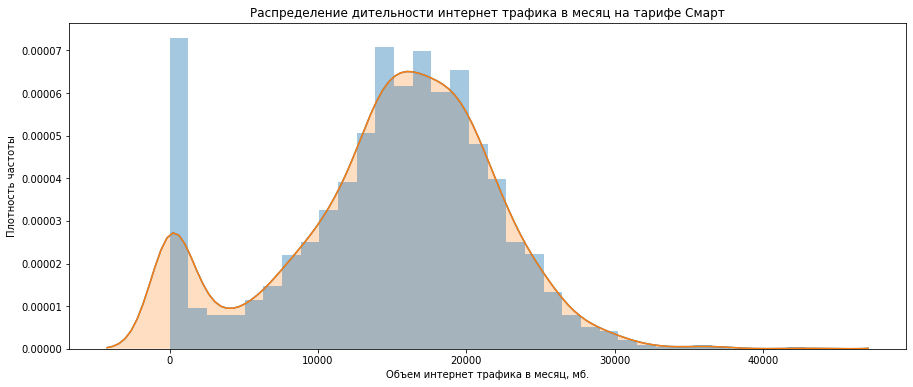

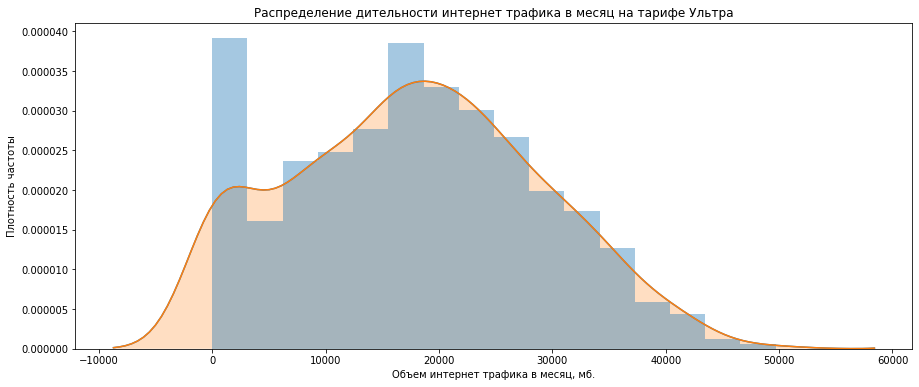

In [19]:
# Посчитаем сколько интернет трафика в среднем требуется пользователям каждого тарифа в месяц
# display(users_info_all.groupby(['mnth','tariff_name'])['sum_duration'].mean())
display(users_info_all.groupby(['tariff_name'])['sum_mb'].mean())

# Посчитаем дисперсию интернет трафика пользователей каждого тарифа в месяц
display(users_info_all.groupby(['tariff_name'])['sum_mb'].var())

# Посчитаем стандартное отклонение интернет трафика пользователей каждого тарифа в месяц
display(users_info_all.groupby(['tariff_name'])['sum_mb'].std())

# hist = users_info_all['sum_duration'].plot(kind='hist',  alpha=0.7, figsize=(10, 5),  density=True)
# hist = users_info_all['sum_duration'].plot.kde()


fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb_plot = sb.distplot(users_info_all.query('tariff_name=="smart"')['sum_mb'])
fig = sb_plot.get_figure()
sb_plot = sb.kdeplot(users_info_all.query('tariff_name=="smart"')['sum_mb'], shade=True)
fig = sb_plot.get_figure()
sb_plot.set(xlabel='Объем интернет трафика в месяц, мб.', ylabel='Плотность частоты', title='Распределение дительности интернет трафика в месяц на тарифе Смарт') 
plt.legend([],[], frameon=False)
plt.show()


fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb_plot = sb.distplot(users_info_all.query('tariff_name=="ultra"')['sum_mb'])
fig = sb_plot.get_figure()
sb_plot = sb.kdeplot(users_info_all.query('tariff_name=="ultra"')['sum_mb'], shade=True)
fig = sb_plot.get_figure()
sb_plot.set(xlabel='Объем интернет трафика в месяц, мб.', ylabel='Плотность частоты', title='Распределение дительности интернет трафика в месяц на тарифе Ультра') 
plt.legend([],[], frameon=False)
plt.show()




На тарифе Смарт месячное распределение интернет трафика похоже на нормальное, пик около нуля минут связан с нашим предположением о пропусках. Значения распределены вокруг среднего (около 14.8 Гб/мес) с дисперсией 51.24 Гб и стандартным отклонением 7.2 Гб.
Распределение слегка ассиметрично с положительной скошенностью. 

На тарифе Ультра месячное распределение интернет трафика также похоже на нормальное. Значения распределены вокруг среднего (17.9 Гб/мес) с дисперсией 120.67 Гб и стандартным отклонением 11 Гб.
Распределение ассиметрично с положительной скошенностью. Дисперсия значений значительно выросла, по сравнению с тарифом Смарт, (более чем в 2 раза), среднее выше на 3,1 Гб.


### Вывод

* Распределения всех графиков похоже на нормальное, не считая пиков около 0. Распределение сообщений ближе к распр. Пуассона;
* все графики скошены в положительную сторону;
* средние значения заметно выше на тарифе Ультра на всех гистограммах;
* разброс значений меньше на тарифе Смарт на всех гистограммах.

<a id="research"></a>
## 4. Проверка гипотез

<a id="ans1"></a>
### 4.1 Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Посчитаем среднюю месячную выручку от пользователя на разных тарифах в выборке

In [20]:
print('Средняя месячная выручка от пользователя на тарифе «Смарт»:', users_info_all.query('tariff_name=="smart"')['revenue'].mean())
print('Средняя месячная выручка от пользователя на тарифе «Ультра»:', users_info_all.query('tariff_name=="ultra"')['revenue'].mean())

# Разница между ними велика:
different_rev = users_info_all.query('tariff_name=="ultra"')['revenue'].abs().mean() - users_info_all.query('tariff_name=="smart"')['revenue'].mean()
different_rev

Средняя месячная выручка от пользователя на тарифе «Смарт»: 1231.53811289658
Средняя месячная выручка от пользователя на тарифе «Ультра»: 2062.934362934363


831.3962500377829

Выборочные средние по выручке очень значительно различаются на разных тарифах в выборке.

Сформулируем 0-гипотезу:
Средняя выручка пользователей тарифов «Ультра» и «Смарт» генеральной совокупности равны

Сформулируем N-гипотезу:
Средняя выручка пользователей тарифов «Ультра» и «Смарт» генеральной совокупности различаются

In [24]:
revenue_smart = users_info_all.query('tariff_name=="smart"')['revenue']
revenue_ultra = users_info_all.query('tariff_name=="ultra"')['revenue']

# print(revenue_smart.var())
# print(revenue_ultra.var())

alpha = 0.05

results = st.ttest_ind(revenue_smart, revenue_ultra, equal_var = False)  

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

668669.4811313096
128407.41984220248
p-значение: 4.929884919808995e-307
Отвергаем нулевую гипотезу


Средняя выручка пользователей тарифов «Ультра» и «Смарт» однозначно различается.

<a id="ans2"></a>
### 4.2 Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Посчитаем среднюю месячную выручку от пользователя по разным регионам в выборке

In [25]:
print('Средняя месячная выручка от пользователя в Москве:', users_info_all.query('city=="Москва"')['revenue'].mean())
print('Средняя месячная выручка от пользователя в других регионах:', users_info_all.query('city!="Москва"')['revenue'].mean())

# Разница между ними велика:
different_rev_reg =users_info_all.query('city=="Москва"')['revenue'].mean() - users_info_all.query('city!="Москва"')['revenue'].mean()
different_rev_reg

Средняя месячная выручка от пользователя в Москве: 1496.3046757164404
Средняя месячная выручка от пользователя в других регионах: 1476.4617857142857
598746.456881428
664660.53658845


19.842890002154718

Выборочные средние по выручке различаются в разных регионах и мск на около 1,5%.

Сформулируем 0-гипотезу:
Средняя выручка пользователей из Москвы и пользователей других регионов генеральной совокупности равны.

Сформулируем N-гипотезу:
Средняя выручка пользователей из Москвы и пользователей других регионов генеральной совокупности различаются.

In [28]:
revenue_msk = users_info_all.query('city=="Москва"')['revenue']
revenue_no_msk = users_info_all.query('city!="Москва"')['revenue']

# print(revenue_msk.var())
# print(revenue_no_msk.var())

alpha = 0.01

results = st.ttest_ind(revenue_smart, revenue_ultra, equal_var = False)  

print('p-значение:', results.pvalue)

if results.pvalue < alpha: 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

598746.456881428
664660.53658845
p-значение: 4.929884919808995e-307
Отвергаем нулевую гипотезу


Средняя выручка пользователей из Москвы и пользователей других регионов генеральной совокупности однозначно различаются.

<a id="summary"></a>
## 5. Общий вывод

Были открыты и изучены данные о поведении клиентов камании "Мегалайн" за 2018 год.

* Проведена предобработка данных, часть пропусков было заполнена исходя из логики данных.<br>
* Типы полей были изменены в соответствии с данными в них и исходя из целей экономии памяти.<br>
* Таблицы были объединены методом merge и сгруппированы по месяцам для последуюющего анализа выборки.<br>
* В сгруппированный датафрэйм было добавлено поле с расчетом выручки от пользователя.

Была проведеан описательная статистика данных:

* Описано поведение клиентов оператора с точки зрения требуемой длительности звонков, количества сообщений, а также интернет трафика в месяц.
* Посчитаны средние, дисперсии и стандартные отклонения этих характеристик
* Построены плотностные гистограммы.
* Сделаны выводы о распределениях:

Распределения всех графиков похоже на нормальное, не считая пиков около 0. Распределение сообщений ближе к распр. Пуассона;<br>
Все графики скошены в положительную сторону;<br>
Средние значения заметно выше на тарифе Ультра на всех гистограммах;<br>
Разброс значений меньше на тарифе Смарт на всех гистограммах.


Проверены следующие гипотезы:
* Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
Гипотеза не отвергнута.
* Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Гипотеза не отвергнута.

Вывод: Тариф "Ультра" в среднем перспективнее, чем тариф "Смарт".













